**Importing Libraries**

In [ ]:
pip install --upgrade scikit-learn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim.models import Word2Vec
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
import pickle
from wordcloud import WordCloud
#To ignore warnings
import warnings
warnings.filterwarnings("ignore")

**Loading Dataset**

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Hate Speech Dataset.zip to Hate Speech Dataset (2).zip


In [ ]:
import zipfile
with zipfile.ZipFile("/content/Hate Speech Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("Hate Speech Dataset")


In [ ]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
# Read the original dataset CSV file
Hate_dataset_path = "/content/Annotations_Metadata.csv"
Hate_df = pd.read_csv(Hate_dataset_path)

In [ ]:
Hate_df

,file_id,user_id,subforum_id,num_contexts,label
0,12834217_1,572066,1346,0,noHate
1,12834217_2,572066,1346,0,noHate
2,12834217_3,572066,1346,0,noHate
3,12834217_4,572066,1346,0,hate
4,12834217_5,572066,1346,0,noHate
...,...,...,...,...,...
10939,33676864_5,734541,1388,0,noHate
10940,33677019_1,735154,1388,0,noHate
10941,33677019_2,735154,1388,0,noHate
10942,33677053_1,572266,1388,0,hate


In [ ]:
#  Read and store content from individual text files
text_files_folder = "/content/Hate Speech Dataset/Hate Speech Dataset/Text file"  # Change this to the folder containing your text files
file_contents = {}
for filename in os.listdir(text_files_folder):
    if filename.endswith(".txt"):
        file_id = filename.split(".")[0]  # Extract file_id from filename
        with open(os.path.join(text_files_folder, filename), "r", encoding="utf-8") as file:
            content = file.read()
            file_contents[file_id] = content

In [ ]:
# Merge the original DataFrame with the content of text files
df = Hate_df.merge(pd.DataFrame.from_dict(file_contents, orient='index', columns=['text']),
                               left_on='file_id', right_index=True, how='left')


In [ ]:
df

,file_id,user_id,subforum_id,num_contexts,label,text
0,12834217_1,572066,1346,0,noHate,"As of March 13th , 2014 , the booklet had been..."
1,12834217_2,572066,1346,0,noHate,In order to help increase the booklets downloa...
2,12834217_3,572066,1346,0,noHate,( Simply copy and paste the following text int...
3,12834217_4,572066,1346,0,hate,Click below for a FREE download of a colorfull...
4,12834217_5,572066,1346,0,noHate,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...
...,...,...,...,...,...,...
10939,33676864_5,734541,1388,0,noHate,"Billy - `` That guy would n't leave me alone ,..."
10940,33677019_1,735154,1388,0,noHate,Wish we at least had a Marine Le Pen to vote f...
10941,33677019_2,735154,1388,0,noHate,Its like the choices are white genocide candid...
10942,33677053_1,572266,1388,0,hate,Why White people used to say that sex was a si...


**Data Cleaning**

In [ ]:
# checking null values
df.isnull().sum()

file_id         0
user_id         0
subforum_id     0
num_contexts    0
label           0
text            0
dtype: int64

In [ ]:
#checking duplicate values
df.duplicated().sum()

0

In [ ]:
# unique value of label
unique_labels = df['label'].unique()
print(unique_labels)


['noHate' 'hate' 'idk/skip' 'relation']


In [ ]:
# count of unique value of label
label_counts = df['label'].value_counts()

print("Size of each unique value in label column:")
print(label_counts)



Size of each unique value in label column:
noHate      9507
hate        1196
relation     168
idk/skip      73
Name: label, dtype: int64


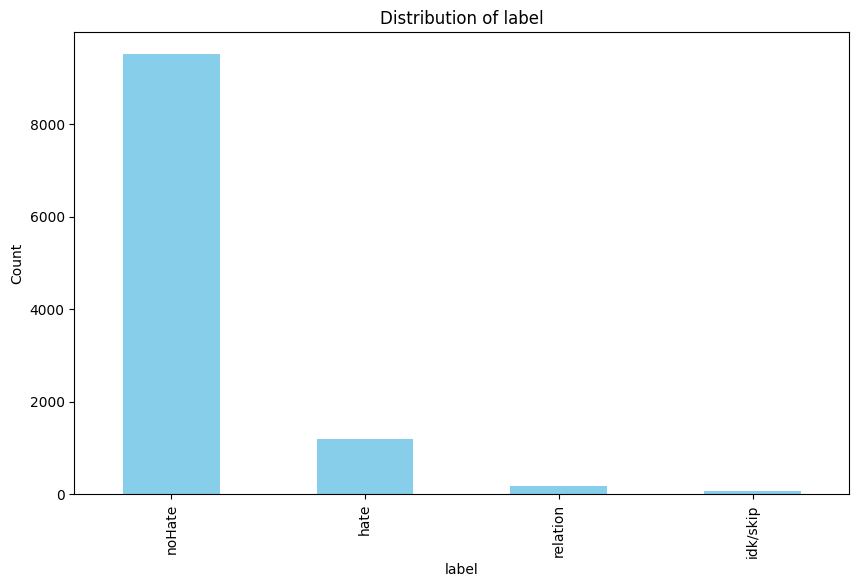

In [ ]:
# Plot the distribution of label
plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of label')
plt.xlabel('label')
plt.ylabel('Count')
plt.show()

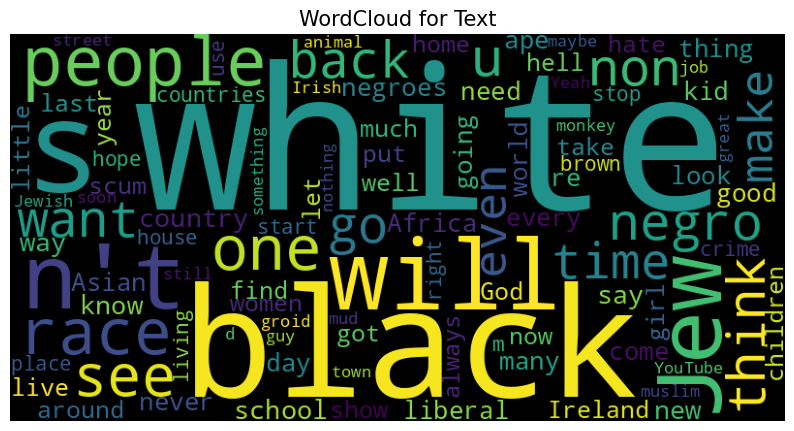

In [ ]:
def plot_word_cloud(data):
    # Joining all the texts to get the corpus
    corpus = " ".join(data['text'])

    plt.figure(figsize=(10, 10))

    # Forming the word cloud
    wc = WordCloud(max_words=100, width=800, height=400, collocations=False).generate(corpus)

    # Plotting the word cloud
    plt.title('WordCloud for Text', fontsize=15)
    plt.axis('off')
    plt.imshow(wc)
    plt.show()
# Filter the DataFrame for rows where the label is 'relation'
hate_df = df[df['label'] == 'hate']

# Plot the word cloud for the 'text' column in relation_df
plot_word_cloud(hate_df)


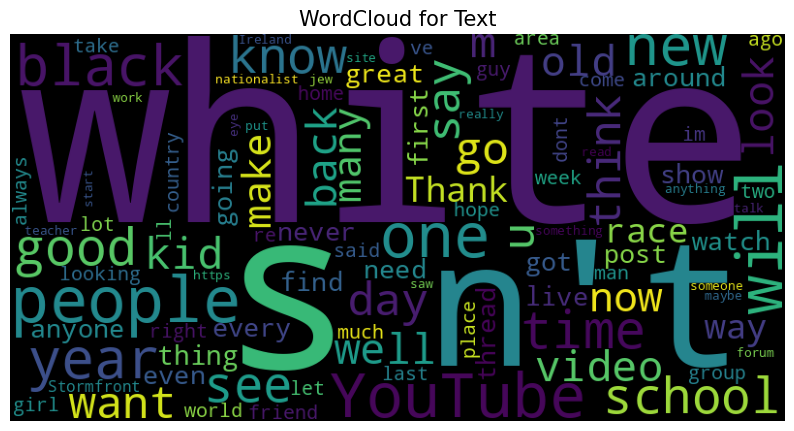

In [ ]:
def plot_word_cloud(data):
    # Joining all the texts to get the corpus
    corpus = " ".join(data['text'])

    plt.figure(figsize=(10, 10))

    # Forming the word cloud
    wc = WordCloud(max_words=100, width=800, height=400, collocations=False).generate(corpus)

    # Plotting the word cloud
    plt.title('WordCloud for Text', fontsize=15)
    plt.axis('off')
    plt.imshow(wc)
    plt.show()
# Filter the DataFrame for rows where the label is 'relation'
noHate_df = df[df['label'] == 'noHate']

# Plot the word cloud for the 'text' column in relation_df
plot_word_cloud(noHate_df)

In [ ]:
# Tokenization
tokens = [word_tokenize(text) for text in df['text']]

In [ ]:
#  Stemming
stemmer = PorterStemmer()
stemmed_tokens = [[stemmer.stem(token) for token in doc] for doc in tokens]

In [ ]:
#  Sentiment Analysis
sia = SentimentIntensityAnalyzer()
sentiments = [sia.polarity_scores(text) for text in df['text']]


In [ ]:
#  Word Embeddings (Word2Vec)
word2vec_model = Word2Vec(tokens, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
#  Topic Modeling (LDA)
dictionary = Dictionary(tokens)
corpus = [dictionary.doc2bow(sentence) for sentence in tokens]
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

**ENCODING**

In [ ]:
# encoding
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])


**Features and Target selection**

In [ ]:
# Features and Target
X = df['text']  # Features
y = df['label']  # Target

**split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# **Model**

LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# Create a pipeline with TF-IDF vectorizer and Logistic Regression
lr_pipeline = make_pipeline(TfidfVectorizer(), LogisticRegression())

# Train the model
lr_pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred_lr = lr_pipeline.predict(X_test)

# Print metrics
print("\nLogistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print("Classification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression:
Accuracy: 0.8798538145271814
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.12      0.19       225
           1       0.50      0.12      0.20        16
           2       0.89      0.99      0.94      1915
           3       0.00      0.00      0.00        33

    accuracy                           0.88      2189
   macro avg       0.50      0.31      0.33      2189
weighted avg       0.84      0.88      0.84      2189



DecisionTree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# Create a pipeline with TF-IDF vectorizer and Decision Tree
dt_pipeline = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier())

# Train the model
dt_pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred_dt = dt_pipeline.predict(X_test)

# Print metrics
print("\nDecision Tree:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt)}")
print("Classification Report:\n", classification_report(y_test, y_pred_dt))



Decision Tree:
Accuracy: 0.845591594335313
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.36      0.36       225
           1       0.78      0.44      0.56        16
           2       0.91      0.92      0.91      1915
           3       0.06      0.03      0.04        33

    accuracy                           0.85      2189
   macro avg       0.53      0.44      0.47      2189
weighted avg       0.84      0.85      0.84      2189



RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# Create a pipeline with TF-IDF vectorizer and Random Forest
rf_pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier())

# Train the model
rf_pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred_rf = rf_pipeline.predict(X_test)

# Print metrics
print("\nRandom Forest:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest:
Accuracy: 0.8775696665143902
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.03      0.05       225
           1       0.67      0.25      0.36        16
           2       0.88      1.00      0.93      1915
           3       0.00      0.00      0.00        33

    accuracy                           0.88      2189
   macro avg       0.57      0.32      0.34      2189
weighted avg       0.85      0.88      0.83      2189



naive_bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# Create a pipeline with TF-IDF vectorizer and Multinomial Naive Bayes
nb_pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Train the model
nb_pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred_nb = nb_pipeline.predict(X_test)

# Print metrics
print("\nMultinomial Naive Bayes:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb)}")
print("Classification Report:\n", classification_report(y_test, y_pred_nb))


Multinomial Naive Bayes:
Accuracy: 0.8748286888990406
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       225
           1       0.00      0.00      0.00        16
           2       0.87      1.00      0.93      1915
           3       0.00      0.00      0.00        33

    accuracy                           0.87      2189
   macro avg       0.22      0.25      0.23      2189
weighted avg       0.77      0.87      0.82      2189



support vector machine

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# Create a pipeline with TF-IDF vectorizer and Support Vector Machine
svm_pipeline = make_pipeline(TfidfVectorizer(), SVC())

# Train the model
svm_pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred_svm = svm_pipeline.predict(X_test)

# Print metrics
print("\nSupport Vector Machine:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print("Classification Report:\n", classification_report(y_test, y_pred_svm))


Support Vector Machine:
Accuracy: 0.8743718592964824
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.01      0.02       225
           1       0.50      0.12      0.20        16
           2       0.88      1.00      0.93      1915
           3       0.00      0.00      0.00        33

    accuracy                           0.87      2189
   macro avg       0.43      0.28      0.29      2189
weighted avg       0.80      0.87      0.82      2189



PREDICTIVE SYSTEM

In [ ]:
# Test text
test_text = ["I watch fights on gay parade in budapest together with my friends from hungary , we were together on vacation in one croatian island , it was great to watch how hungarian nationalists were smashing gay parade btw I have some hungarian blood , my grandmother was hungarian Kitartas !"]

# Make predictions
y_pred_rf = rf_pipeline.predict(test_text)

# Map predictions to labels
predicted_label = label_encoder.inverse_transform(y_pred_rf)

# Print the result
print(f"Predicted speech: {predicted_label[0]}")

Predicted speech: hate
